# Document Classifier - Jupyter implementation

## 0. Set up Bedrock Client

In [ ]:
import os
import logging

import boto3


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

os.environ['AWS_BEARER_TOKEN_BEDROCK'] = "<enter-your-API-key-here>"

if 'AWS_BEARER_TOKEN_BEDROCK' not in os.environ:
    print("AWS API key (token) variable is not set in the environment!")
    print("Please set it using the following command in your terminal:\n")
    print('export AWS_BEARER_TOKEN_BEDROCK="<your_token_here>"')
    print("\nExiting...")
    raise ValueError("AWS_BEARER_TOKEN_BEDROCK environment variable must be set")
else:
    print("AWS_BEARER_TOKEN_BEDROCK environment variable is set")


# Initialize the Bedrock client
bedrock_client = boto3.client(
    service_name="bedrock",
    region_name="us-east-1"
)

# Test connection - list available models
try:
    response = bedrock_client.list_foundation_models()
    print(f"Successfully connected to Bedrock. Found {len(response['modelSummaries'])} models.")
    print(f"Printing Anthropic models:")
    for model in response['modelSummaries']:
        if model['modelId'].startswith('anthropic'):
        	print(f"  - {model['modelId']}: {model.get('modelName', 'N/A')}")
except Exception as e:
    logger.error(f"Failed to connect to Bedrock: {e}")
    raise

# Initialize an Amazon BedrockRuntime client
runtime_client = boto3.client(
    service_name="bedrock-runtime",
    region_name="us-east-1"
)

AWS_BEARER_TOKEN_BEDROCK environment variable is set


INFO:botocore.tokens:Found token in environment variables.


Successfully connected to Bedrock. Found 91 models.
Printing Anthropic models:
  - anthropic.claude-opus-4-1-20250805-v1:0: Claude Opus 4.1
  - anthropic.claude-instant-v1:2:100k: Claude Instant
  - anthropic.claude-instant-v1: Claude Instant
  - anthropic.claude-v2:0:18k: Claude
  - anthropic.claude-v2:0:100k: Claude
  - anthropic.claude-v2:1:18k: Claude
  - anthropic.claude-v2:1:200k: Claude
  - anthropic.claude-v2:1: Claude
  - anthropic.claude-v2: Claude
  - anthropic.claude-3-sonnet-20240229-v1:0:28k: Claude 3 Sonnet
  - anthropic.claude-3-sonnet-20240229-v1:0:200k: Claude 3 Sonnet
  - anthropic.claude-3-sonnet-20240229-v1:0: Claude 3 Sonnet
  - anthropic.claude-3-haiku-20240307-v1:0:48k: Claude 3 Haiku
  - anthropic.claude-3-haiku-20240307-v1:0:200k: Claude 3 Haiku
  - anthropic.claude-3-haiku-20240307-v1:0: Claude 3 Haiku
  - anthropic.claude-3-opus-20240229-v1:0:12k: Claude 3 Opus
  - anthropic.claude-3-opus-20240229-v1:0:28k: Claude 3 Opus
  - anthropic.claude-3-opus-20240229-

INFO:botocore.tokens:Found token in environment variables.


## 1. Data Loading - Custom Classes

In [ ]:
from dataclasses import dataclass

import pandas as pd


@dataclass
class Document:
    """Data class to represent a document"""
    category: int
    text: str
    
    def __repr__(self):
        return f"Document(category={self.category}, text_length={len(self.text)})"
    
class DataLoader:
    """Class to handle data loading and processing"""
    
    @staticmethod
    def load_data(filepath: str, has_labels: bool = True) -> list[Document]:
        """Load documents from text file"""
        documents = []
        
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                
            # First line contains the count
            count = int(lines[0].strip())
            
            # Process each document
            for i in range(1, min(count + 1, len(lines))):
                line = lines[i].strip()
                if has_labels:
                    # Extract category and text
                    parts = line.split(' ', 1)
                    if len(parts) == 2:
                        category = int(parts[0])
                        text = parts[1]
                        documents.append(Document(category=category, text=text))
                else:
                    # For test data, category is in the text (we'll extract it for evaluation)
                    parts = line.split(' ', 1)
                    if len(parts) == 2:
                        category = int(parts[0])
                        text = parts[1]
                        documents.append(Document(category=category, text=text))
                    
            logger.info(f"Loaded {len(documents)} documents from {filepath}")
            return documents
            
        except Exception as e:
            logger.error(f"Error loading data from {filepath}: {e}")
            raise

# Load training and testing data
train_documents = DataLoader.load_data('trainingdata.txt', has_labels=True)
test_documents = DataLoader.load_data('testingdata.txt', has_labels=True)
print(train_documents)

print(f"Training documents: {len(train_documents)}")
print(f"Testing documents: {len(test_documents)}")
print(f"\nTraining category distribution:")
train_df = pd.DataFrame([(d.category, len(d.text)) for d in train_documents], 
                        columns=['category', 'text_length'])
print(train_df['category'].value_counts().sort_index())
print(train_df['text_length'].describe())


INFO:__main__:Loaded 48 documents from trainingdata.txt
INFO:__main__:Loaded 24 documents from testingdata.txt


[Document(category=1, text_length=360), Document(category=1, text_length=220), Document(category=1, text_length=464), Document(category=1, text_length=150), Document(category=1, text_length=1345), Document(category=1, text_length=1097), Document(category=2, text_length=841), Document(category=2, text_length=648), Document(category=2, text_length=678), Document(category=2, text_length=2982), Document(category=2, text_length=252), Document(category=2, text_length=345), Document(category=3, text_length=580), Document(category=3, text_length=752), Document(category=3, text_length=311), Document(category=3, text_length=5164), Document(category=3, text_length=2065), Document(category=3, text_length=709), Document(category=4, text_length=550), Document(category=4, text_length=1308), Document(category=4, text_length=852), Document(category=4, text_length=581), Document(category=4, text_length=538), Document(category=4, text_length=1238), Document(category=5, text_length=348), Document(category

## 2. Bedrock Classifier - Custom Classes with Field Validation

In [236]:
from typing import Any, Optional

from pydantic import BaseModel, Field, field_validator

class CategoryDescription(BaseModel):
    """Pydantic model for a single category description"""
    category_id: int = Field(..., ge=1, description="Category ID")
    description: str = Field(..., min_length=10, description="Category description")

    @field_validator('description')
    @classmethod
    def description_must_not_be_empty(cls, v):
        if not v.strip():
            raise ValueError('Description cannot be empty')
        return v.strip()

class CategoryDescriptions(BaseModel):
    """Pydantic model for all category descriptions"""
    descriptions: dict[int, str] = Field(..., description="Dictionary mapping category IDs to descriptions")
    
    def __init__(self, expected_categories: set[int], **data):
        self.expected_categories = expected_categories
        super().__init__(**data)

    @field_validator('descriptions')
    @classmethod
    def validate_categories(cls, v):
        expected_categories = getattr(cls, '_expected_categories', set(range(1, 9)))
        actual_categories = set(v.keys())
        
        if actual_categories != expected_categories:
            missing = expected_categories - actual_categories
            extra = actual_categories - expected_categories
            error_msg = []
            if missing:
                error_msg.append(f"Missing categories: {sorted(missing)}")
            if extra:
                error_msg.append(f"Extra categories: {sorted(extra)}")
            raise ValueError("; ".join(error_msg))
        
        # Validate each description
        for cat_id, desc in v.items():
            if not desc or not desc.strip():
                raise ValueError(f"Category {cat_id} description cannot be empty")
            if len(desc.strip()) < 10:
                raise ValueError(f"Category {cat_id} description too short (min 10 characters)")
        return v

class ClassificationResult(BaseModel):
    """Pydantic model for classification result"""
    category: int = Field(..., ge=1, description="Predicted category")
    confidence: float = Field(..., ge=0.0, le=1.0, description="Confidence score between 0 and 1")
    reasoning: Optional[str] = Field(None, description="Reasoning for the classification")
    
    # Class variable to store valid categories (will be set dynamically)
    _valid_categories: set[int] = set(range(1, 9))  # default fallback
    
    @field_validator('category')
    @classmethod
    def validate_category_range(cls, v):
        if v not in cls._valid_categories:
            raise ValueError(f"Category {v} not in valid categories: {sorted(cls._valid_categories)}")
        return v
    
    @field_validator('confidence')
    @classmethod
    def round_confidence(cls, v):
        return round(v, 3)
    
class SchemaGenerator:
    """Helper class to generate JSON schemas dynamically based on categories"""
    
    @staticmethod
    def generate_category_descriptions_schema(categories: set[int]) -> dict[str, Any]:
        """Generate schema for category descriptions based on available categories"""
        properties = {}
        required = []
        
        for cat in sorted(categories):
            cat_str = str(cat)
            properties[cat_str] = {
                "type": "string", 
                "minLength": 10,
                "description": f"Description for category {cat}"
            }
            required.append(cat_str)
        
        return {
            "type": "object",
            "properties": {
                "categories": {
                    "type": "object",
                    "properties": properties,
                    "required": required,
                    "additionalProperties": False
                }
            },
            "required": ["categories"],
            "additionalProperties": False
        }
    
    @staticmethod
    def generate_classification_schema(categories: set[int], include_reasoning: bool = True) -> dict[str, Any]:
        """Generate schema for classification based on available categories"""
        min_cat = min(categories)
        max_cat = max(categories)
        
        properties = {
            "category": {
                "type": "integer",
                "minimum": min_cat,
                "maximum": max_cat,
                "description": f"The predicted category number from {min_cat} to {max_cat}",
                "enum": sorted(list(categories))  # Restrict to only valid categories
            },
            "confidence": {
                "type": "number",
                "minimum": 0.0,
                "maximum": 1.0,
                "description": "Confidence score between 0.0 and 1.0"
            }
        }
        
        required = ["category", "confidence"]
        
        if include_reasoning:
            properties["reasoning"] = {
                "type": "string",
                "minLength": 10,
                "description": "Brief explanation of the classification reasoning"
            }
        
        return {
            "type": "object",
            "properties": properties,
            "required": required,
            "additionalProperties": False
        }

class PromptGenerator:
    """Helper class to generate prompts dynamically based on categories and training data"""
    
    @staticmethod
    def generate_description_prompt(training_examples: dict[int, list[str]], categories: set[int]) -> str:
        """Generate description generation prompt based on training examples"""
        prompt = f"""Analyze these documents grouped by category and provide a concise description for each category.
                Training examples by category:"""

        for cat in sorted(categories):
            if cat in training_examples and training_examples[cat]:
                prompt += f"\nCategory {cat}:\n"
                for i, text in enumerate(training_examples[cat][:3], 1):
                    prompt += f"  Example {i}: {text[:200]}...\n"
            else:
                prompt += f"\nCategory {cat}: (No training examples available)\n"
        
        category_list = ", ".join(str(c) for c in sorted(categories))
        prompt += f"""\nBased on these examples, provide a brief, clear description for each category.
                Use the provided tool to return your response in the required JSON format with categories {category_list}."""

        return prompt
    
    @staticmethod
    def generate_classification_prompt(text: str, 
                                     category_descriptions: dict[int, str], 
                                     training_examples: dict[int, list[str]], 
                                     categories: set[int], 
                                     use_cot: bool = True) -> str:
        """Generate classification prompt based on category data"""
        
        prompt = """You are an expert document classifier for news and text documents.
                    Categories and their descriptions:"""

        # Add category descriptions
        for cat_id in sorted(categories):
            if cat_id in category_descriptions:
                description = category_descriptions[cat_id]
                prompt += f"\n{cat_id}. {description}"
            else:
                prompt += f"\n{cat_id}. (No description available)"
        
        prompt += "\n\nExamples for each category:"

        # Add one example per category
        for cat in sorted(categories):
            if cat in training_examples and training_examples[cat]:
                prompt += f"\nCategory {cat}: {training_examples[cat][0][:150]}..."
            else:
                prompt += f"\nCategory {cat}: (No example available)"
        
        prompt += f"\n\nDocument to classify:\n{text}\n\n"
        
        category_range = f"{min(categories)}-{max(categories)}" if len(categories) > 1 else str(list(categories)[0])
        
        if use_cot:
            prompt += f"""Analyze this document step by step:
                    1. Identify the main topics and themes
                    2. Match them to the most appropriate category
                    3. Assess your confidence level (0.0-1.0)
                    4. Provide reasoning for your decision

                    Use the provided tool to return your classification with category ({category_range}), confidence score, and reasoning."""
        else:
            prompt += f"""Classify this document into one of the available categories based on the descriptions above.
                    Use the provided tool to return your classification with category ({category_range}) and confidence score."""
        
        return prompt


In [247]:
import re
import json
import time

from tqdm import tqdm


class BedrockClassifier:
    """Document classifier using Amazon Bedrock LLMs with dynamic JSON schema tool configuration"""

    def __init__(self, 
                 bedrock_runtime, 
                 model_id: str = "us.anthropic.claude-sonnet-4-20250514-v1:0", 
                 descriptions_file: str = "category_descriptions.json"):
        self.bedrock_runtime = bedrock_runtime
        self.model_id = model_id
        self.category_descriptions = None
        self.descriptions_file = descriptions_file
        self.training_examples = {}
        self.categories = set()

        # Initialize helper classes
        self.schema_generator = SchemaGenerator()
        self.prompt_generator = PromptGenerator()

        # Try to load existing descriptions
        self._load_category_descriptions()

    def discover_categories(self, documents: list[Document]) -> set[int]:
        """Discover all unique categories in the dataset"""
        categories = set()
        for doc in documents:
            categories.add(doc.category)
        
        logger.info(f"Discovered categories: {sorted(categories)}")
        return categories

    def analyze_categories(self, documents: list[Document]) -> dict[int, list[str]]:
        """Group documents by category for analysis"""
        # Update categories based on actual data
        self.categories = self.discover_categories(documents)

        categories = {}
        for doc in documents:
            if doc.category not in categories:
                categories[doc.category] = []
            categories[doc.category].append(doc.text)

        logger.info(f"Analyzed {len(documents)} documents into {len(categories)} categories: {sorted(categories.keys())}")
        return categories

    def prepare_training_examples(self, documents: list[Document], samples_per_category: int = 3) -> None:
        """Prepare training examples for few-shot learning"""
        categories = self.analyze_categories(documents)
        
        for cat, texts in categories.items():
            # Select diverse examples
            sample_size = min(samples_per_category, len(texts))
            self.training_examples[cat] = texts[:sample_size]
            
        logger.info(f"Prepared {sum(len(v) for v in self.training_examples.values())} training examples for {len(self.categories)} categories")
    
    def generate_category_descriptions(self) -> dict[int, str]:
        """Generate descriptions for each category based on training examples"""
        if not self.categories:
            raise ValueError("No categories discovered. Please run prepare_training_examples() first.")
        
        schema = self.schema_generator.generate_category_descriptions_schema(self.categories)
        prompt = self.prompt_generator.generate_description_prompt(self.training_examples, self.categories)
        
        try:
            response_json = self._invoke_model_with_tool(
                prompt, 
                "generate_category_descriptions",
                "Generate category descriptions based on training examples",
                schema
            )

            # Parse the structured response to extract descriptions
            self.category_descriptions = self._parse_description_response(response_json)
            
            # Save descriptions to a file
            self._save_category_descriptions()
            
            return self.category_descriptions
        except Exception as e:
            logger.error(f"Error generating descriptions: {e}")
            return {}
    
    def classify_document(self, text: str, use_cot: bool = True) -> tuple[int, float, Optional[str]]:
        """Classify a single document"""
        if not self.categories:
            raise ValueError("No categories available. Please run prepare_training_examples() first.")
        
        # Check if category descriptions are available
        if not self.category_descriptions:
            if not self.training_examples:
                raise ValueError("No category descriptions available and no training examples prepared.")
            else:
                logger.warning("Category descriptions not found. Generating them now...")
                self.generate_category_descriptions()
                
        if not self.category_descriptions:
            raise ValueError("Failed to generate category descriptions.")
        
        # Generate dynamic schema and prompt
        schema = self.schema_generator.generate_classification_schema(self.categories, use_cot)
        prompt = self.prompt_generator.generate_classification_prompt(
            text, self.category_descriptions, self.training_examples, self.categories, use_cot
        )

        try:
            tool_name = "classify_document_with_reasoning" if use_cot else "classify_document"
            tool_description = "Classify document with reasoning" if use_cot else "Classify document"
            
            response_json = self._invoke_model_with_tool(
                prompt, 
                tool_name,
                tool_description,
                schema
            )
            
            # Parse structured response
            category = response_json.get('category', 1)
            confidence = response_json.get('confidence', 0.5)
            reasoning = response_json.get('reasoning') if use_cot else None

            # Validate category is in valid range
            if category not in self.categories:
                logger.warning(f"Model returned invalid category {category}, using fallback {min(self.categories)}")
                category = min(self.categories)

            # Set valid categories for validation
            ClassificationResult._valid_categories = self.categories

            validated_result = ClassificationResult(
                category=category,
                confidence=confidence,
                reasoning=reasoning
            )
            
            return validated_result.category, validated_result.confidence, validated_result.reasoning
            
        except Exception as e:
            logger.error(f"Classification error: {e}")
            fallback_category = min(self.categories) if self.categories else 1
            return fallback_category, 0.0, None


    def classify_batch(self, documents: list[Document], use_cot: bool = True) -> list[tuple[int, float, Optional[str]]]:
        """Classify multiple documents with progress tracking"""
        results = []

        for doc in tqdm(documents, desc="Classifying documents"):
            # Add delay to avoid rate limiting
            time.sleep(0.5)
            result = self.classify_document(doc.text, use_cot)
            results.append(result)

        return results
    
    def get_category_info(self) -> dict[str, Any]:
        """Get information about discovered categories"""
        return {
            'categories': sorted(list(self.categories)),
            'num_categories': len(self.categories),
            'category_range': f"{min(self.categories)}-{max(self.categories)}" if self.categories else "None",
            'has_descriptions': self.category_descriptions is not None,
            'training_examples_count': {cat: len(examples) for cat, examples in self.training_examples.items()}
        }
    
    def _invoke_model_with_tool(self, prompt: str, tool_name: str, tool_description: str, schema: dict[str, Any]) -> dict[str, Any]:
        """Invoke the Bedrock model via Converse API with error handling"""
        max_retries = 3
        
        for attempt in range(max_retries):
            try:
                # Prepare the request based on model type
                messages = [{"role": "user", "content": [{"text": prompt}]}]
                
                tool_config = {
                    "tools": [
                        {
                            "toolSpec": {
                                "name": tool_name,
                                "description": tool_description,
                                "inputSchema": {
                                    "json": schema
                                }
                            }
                        }
                    ],
                    "toolChoice": {
                        "tool": {
                            "name": tool_name
                        }
                    }
                }

                response = self.bedrock_runtime.converse(
                    modelId=self.model_id,
                    messages=messages,
                    toolConfig=tool_config,
                    inferenceConfig={
                        "temperature": 0.1, 
                        "maxTokens": 4000
                    }
                )
                
                # Extract tool use result
                output_message = response.get('output', {}).get('message', {})
                content = output_message.get('content', [])
                
                for item in content:
                    if 'toolUse' in item:
                        tool_use = item['toolUse']
                        if tool_use.get('name') == tool_name:
                            return tool_use.get('input', {})
                
                # If no tool use found, try to extract from text content
                for item in content:
                    if 'text' in item:
                        text_content = item['text']
                        # Try to extract JSON from text
                        try:
                            # Look for JSON in the response
                            json_match = re.search(r'\{.*\}', text_content, re.DOTALL)
                            if json_match:
                                return json.loads(json_match.group())
                        except:
                            pass

                raise ValueError("No valid tool response found")

            except Exception as e:
                logger.warning(f"Attempt {attempt + 1}/{max_retries} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt) # Exponential backoff
                else:
                    raise

    def _parse_description_response(self, response_json: dict[str, Any]) -> dict[int, str]:
        """Parse category descriptions from JSON response"""
        try:
            categories_data = response_json.get('categories', {})
            descriptions = {}
            
            for cat_str, desc in categories_data.items():
                try:
                    cat_id = int(cat_str)
                    if cat_id in self.categories:
                        descriptions[cat_id] = desc.strip()
                except ValueError:
                    logger.warning(f"Invalid category key in response: {cat_str}")
            
            # Fill missing categories with placeholder descriptions
            for cat in self.categories:
                if cat not in descriptions:
                    descriptions[cat] = f"Category {cat} description (auto-generated)"
                    logger.warning(f"Missing description for category {cat}, using placeholder")
            
            return descriptions
            
        except Exception as e:
            logger.error(f"Error parsing description response: {e}")
            # Return placeholder descriptions for all categories
            return {cat: f"Category {cat} description (error fallback)" for cat in self.categories}
    
    def _load_category_descriptions(self) -> None:
        """Load category descriptions from JSON file if it exists"""
        if os.path.exists(self.descriptions_file):
            try:
                with open(self.descriptions_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                # Handle different file formats
                self.category_descriptions = {}
                descriptions_dict = data['descriptions']
                metadata = data['metadata']
                logger.info(f"Loaded file with metadata: {metadata.get('num_categories', 'unknown')} categories")
                
                for k, v in descriptions_dict.items():
                    try:
                        cat_id = int(k)
                        self.category_descriptions[cat_id] = v
                    except ValueError:
                        logger.warning(f"Invalid category key in descriptions: {k}")
                
                # Also update categories from saved descriptions
                if self.category_descriptions:
                    saved_categories = set(self.category_descriptions.keys())
                    if not self.categories:  # If no categories discovered yet
                        self.categories = saved_categories
                        logger.info(f"Loaded categories from saved descriptions: {sorted(self.categories)}")
                
                logger.info(f"Loaded category descriptions from {self.descriptions_file}")
            except Exception as e:
                logger.error(f"Error loading category descriptions: {e}")
                self.category_descriptions = None

    def _save_category_descriptions(self) -> None:
        """Save category descriptions to JSON file"""
        if self.category_descriptions:
            try:
                # Save with metadata about categories
                save_data = {
                    "descriptions": self.category_descriptions,
                    "metadata": {
                        "categories": sorted(list(self.categories)),
                        "num_categories": len(self.categories),
                        "generated_at": time.strftime("%Y-%m-%d %H:%M:%S")
                    }
                }
                with open(self.descriptions_file, 'w', encoding='utf-8') as f:
                    json.dump(save_data, f, ensure_ascii=False, indent=4)
                logger.info(f"Saved category descriptions to {self.descriptions_file}")
            except Exception as e:
                logger.error(f"Error saving category descriptions: {e}")

# Initialize classifier
classifier = BedrockClassifier(runtime_client)
classifier.prepare_training_examples(train_documents, samples_per_category=3)

print("Classifier initialized successfully!")

# Show category information
category_info = classifier.get_category_info()
print(f"Discovered categories: {category_info['categories']}")

INFO:__main__:Loaded file with metadata: 8 categories
INFO:__main__:Loaded categories from saved descriptions: [1, 2, 3, 4, 5, 6, 7, 8]
INFO:__main__:Loaded category descriptions from category_descriptions.json
INFO:__main__:Discovered categories: [1, 2, 3, 4, 5, 6, 7, 8]
INFO:__main__:Analyzed 48 documents into 8 categories: [1, 2, 3, 4, 5, 6, 7, 8]
INFO:__main__:Prepared 24 training examples for 8 categories
INFO:__main__:Loaded categories from saved descriptions: [1, 2, 3, 4, 5, 6, 7, 8]
INFO:__main__:Loaded category descriptions from category_descriptions.json
INFO:__main__:Discovered categories: [1, 2, 3, 4, 5, 6, 7, 8]
INFO:__main__:Analyzed 48 documents into 8 categories: [1, 2, 3, 4, 5, 6, 7, 8]
INFO:__main__:Prepared 24 training examples for 8 categories


Classifier initialized successfully!
Discovered categories: [1, 2, 3, 4, 5, 6, 7, 8]


## 3. Category Description Generation

In [248]:
# Generate category descriptions
print("Generating category descriptions based on training data...\n")
category_descriptions = classifier.generate_category_descriptions()

print("Category Descriptions:")
print("="*80)
for cat_id, description in sorted(category_descriptions.items()):
    print(f"Category {cat_id}: {description}")
print("="*80)

Generating category descriptions based on training data...



INFO:__main__:Saved category descriptions to category_descriptions.json


Category Descriptions:
Category 1: Corporate financial announcements including earnings reports, stock splits, quarterly results, and financial performance metrics of individual companies.
Category 2: Corporate transactions and business activities such as mergers, acquisitions, asset sales, subsidiary disposals, and legal claims involving companies.
Category 3: International trade policy and negotiations including GATT disputes, trade legislation, multilateral trade talks, and government trade appointments.
Category 4: Transportation and shipping disruptions caused by weather conditions, labor strikes, and infrastructure issues affecting maritime and river transport.
Category 5: Agricultural trade and policy including grain exports, crop programs, agricultural subsidies, and farming-related government policies and statistics.
Category 6: Oil and energy sector news covering crude oil prices, production levels, OPEC activities, and petroleum industry developments and market conditions.
C

## 4. Document Classification - Training & Evaluation

In [249]:
# Classify test documents
print(f"Classifying {len(test_documents)} test documents...")

# Perform classification
predictions = classifier.classify_batch(test_documents, use_cot=True)

# Extract predictions and ground truth
y_true = [doc.category for doc in test_documents]
y_pred = [pred[0] for pred in predictions]
confidences = [pred[1] for pred in predictions]
reasoning = [pred[2] if len(pred) > 2 else None for pred in predictions]

# Create results DataFrame
results_df = pd.DataFrame({
    'true_category': y_true,
    'predicted_category': y_pred,
    'confidence': confidences,
	'reasoning': reasoning,
    'correct': [t == p for t, p in zip(y_true, y_pred)],
    'text_preview': [doc.text[:100] + '...' for doc in test_documents]
})

print("\nClassification Results Summary:")
print(f"Total documents: {len(results_df)}")
print(f"Correct predictions: {results_df['correct'].sum()}")
print(f"Accuracy: {results_df['correct'].mean():.2%}")
print(f"Average confidence: {results_df['confidence'].mean():.2f}")

# Show sample results
print("\nSample Predictions:")
sample_results = results_df[['true_category', 'predicted_category', 'confidence', 'correct', 'reasoning']].head(5)
for idx, row in sample_results.iterrows():
    print(f"Document {idx+1}: True={row['true_category']}, Pred={row['predicted_category']}, "
          f"Conf={row['confidence']:.3f}, Correct={row['correct']}")
    if row['reasoning']:
        print(f"  Reasoning: {row['reasoning'][:100]}...")
    print()

Classifying 24 test documents...


Classifying documents: 100%|██████████| 24/24 [02:00<00:00,  5.01s/it]


Classification Results Summary:
Total documents: 24
Correct predictions: 24
Accuracy: 100.00%
Average confidence: 0.94

Sample Predictions:
Document 1: True=1, Pred=1, Conf=0.950, Correct=True
  Reasoning: This document reports Thackeray Corp's annual financial results including year loss, operating share...

Document 2: True=1, Pred=1, Conf=0.900, Correct=True
  Reasoning: This document is primarily about Allied Lyons' financial performance and earnings outlook. The chair...

Document 3: True=1, Pred=1, Conf=0.950, Correct=True
  Reasoning: This document reports financial performance metrics for Dryclean USA, including net earnings per sha...

Document 4: True=2, Pred=2, Conf=0.950, Correct=True
  Reasoning: This document describes First Financial Management Corp acquiring data processing contracts and asse...

Document 5: True=2, Pred=2, Conf=0.950, Correct=True
  Reasoning: This document is clearly about a corporate merger between Delta Air Lines and Western Air Lines sche...



## 5. Classification Report - F1 Score

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import numpy as np


# Calculate detailed metrics
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(y_true, y_pred, target_names=[f"Category {i}" for i in range(1, 9)]))

# Calculate F1 scores
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_per_class = f1_score(y_true, y_pred, average=None)

print("\nF1 Scores:")
print(f"Macro F1 Score: {f1_macro:.3f}")
print(f"Weighted F1 Score: {f1_weighted:.3f}")
print("\nPer-class F1 Scores:")
for i, score in enumerate(f1_per_class, 1):
    if not np.isnan(score):  # Only print if class exists in test set
        print(f"  Category {i}: {score:.3f}")


Detailed Classification Report:
              precision    recall  f1-score   support

  Category 1       1.00      1.00      1.00         3
  Category 2       1.00      1.00      1.00         3
  Category 3       1.00      1.00      1.00         3
  Category 4       1.00      1.00      1.00         3
  Category 5       1.00      1.00      1.00         3
  Category 6       1.00      1.00      1.00         3
  Category 7       1.00      1.00      1.00         3
  Category 8       1.00      1.00      1.00         3

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24


F1 Scores:
Macro F1 Score: 1.000
Weighted F1 Score: 1.000

Per-class F1 Scores:
  Category 1: 1.000
  Category 2: 1.000
  Category 3: 1.000
  Category 4: 1.000
  Category 5: 1.000
  Category 6: 1.000
  Category 7: 1.000
  Category 8: 1.000


## 6. Confusion Matrix

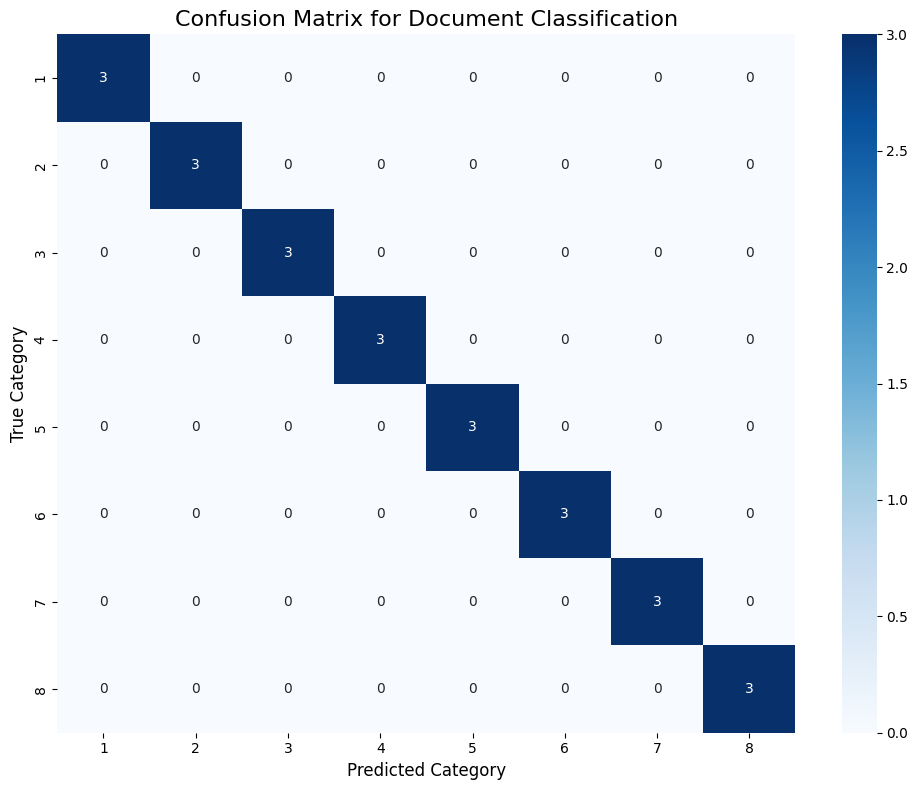


Confusion Matrix Legend:
- Diagonal values show correct predictions
- Off-diagonal values show misclassifications
- Higher values on diagonal indicate better performance


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title('Confusion Matrix for Document Classification', fontsize=16)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Legend:")
print("- Diagonal values show correct predictions")
print("- Off-diagonal values show misclassifications")
print("- Higher values on diagonal indicate better performance")

In [242]:
# Analyze misclassifications
misclassified = results_df[~results_df['correct']]

print(f"\nMisclassification Analysis:")
print(f"Total misclassified: {len(misclassified)} out of {len(results_df)} ({len(misclassified)/len(results_df)*100:.1f}%)")

if len(misclassified) > 0:
    print("\nMisclassification patterns:")
    confusion_pairs = misclassified.groupby(['true_category', 'predicted_category']).size().reset_index(name='count')
    confusion_pairs = confusion_pairs.sort_values('count', ascending=False)
    
    for _, row in confusion_pairs.head(5).iterrows():
        print(f"  True: Category {row['true_category']} -> Predicted: Category {row['predicted_category']}: {row['count']} times")
    
    print("\nLow confidence predictions:")
    low_conf = results_df[results_df['confidence'] < 0.7].sort_values('confidence')
    if len(low_conf) > 0:
        print(f"Found {len(low_conf)} predictions with confidence < 0.7")
        for _, row in low_conf.head(3).iterrows():
            print(f"  Doc preview: {row['text_preview'][:50]}...")
            print(f"    True: {row['true_category']}, Predicted: {row['predicted_category']}, Confidence: {row['confidence']:.2f}")
else:
    print("Perfect classification! No misclassifications found.")


Misclassification Analysis:
Total misclassified: 0 out of 24 (0.0%)
Perfect classification! No misclassifications found.


In [ ]:
# Save classification results to CSV
output_filename = 'classification_results.csv'
results_df.to_csv(output_filename, index=False)
print(f"Results saved to {output_filename}")

# Save category descriptions to JSON
with open('category_descriptions.json', 'w') as f:
    json.dump(category_descriptions, f, indent=2)
print("Category descriptions saved to category_descriptions.json")

# Print final predictions for test documents
print("\nFinal Predictions for Test Documents:")
print("="*50)
for i, (doc, pred, conf) in enumerate(zip(test_documents, y_pred, confidences), 1):
    print(f"Document {i}: Category {pred} (Confidence: {conf:.2f})")

Results saved to classification_results.csv
Category descriptions saved to category_descriptions.json

Final Predictions for Test Documents:
Document 1: Category 1 (Confidence: 0.95)
Document 2: Category 1 (Confidence: 0.90)
Document 3: Category 1 (Confidence: 0.95)
Document 4: Category 2 (Confidence: 0.95)
Document 5: Category 2 (Confidence: 0.95)
Document 6: Category 2 (Confidence: 0.90)
Document 7: Category 3 (Confidence: 0.95)
Document 8: Category 3 (Confidence: 0.95)
Document 9: Category 3 (Confidence: 0.95)
Document 10: Category 4 (Confidence: 0.85)
Document 11: Category 4 (Confidence: 0.85)
Document 12: Category 4 (Confidence: 0.95)
Document 13: Category 5 (Confidence: 0.95)
Document 14: Category 5 (Confidence: 0.95)
Document 15: Category 5 (Confidence: 0.95)
Document 16: Category 6 (Confidence: 0.85)
Document 17: Category 6 (Confidence: 0.85)
Document 18: Category 6 (Confidence: 0.90)
Document 19: Category 7 (Confidence: 0.95)
Document 20: Category 7 (Confidence: 0.90)
Document